**ANALYSIS OF WINE REGIONS BASED ON PHYSICAL AND CHEMICAL CHARACTARISTICS**

Contributors:
>12981056 - Heather Au 
>
>61499182 - Connor Moynihan

In [2]:
library(tidyverse)
library (tidymodels)
library(repr)
library(ggplot2)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


**Introduction**

In a chemical analysis of wine, various components such as alcohol content, acidity, and phenolic compounds are  examined. This detailed analysis provides valuable insights into the composition and quality of the specific wines. Therefore, given the characteristics of the wine, can we predict its cultivator? The wine dataset contains a chemical analysis of wine grown in the same region in Italy and are derived from three different cultivators labeled as 1, 2 and 3. There are 13 attributes that numerically describe the wine with characteristics such as color intensity, hue and proline.


**Preliminary Exploratory Data Analysis**

In [4]:
wine <- read_csv(url("https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv"))


wine_tidy <- mutate (wine, Wine = as_factor (Wine))
wine_tidy

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): Wine, Alcohol, Malic.acid, Ash, Acl, Mg, Phenols, Flavanoids, Nonf...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [5]:
set.seed (1)

#Split the data into training and testing data
wine_split <- initial_split (wine_tidy, prop = 0.75, strata = Wine)
wine_train <- training (wine_split)
wine_test <- testing (wine_split)

wine_train_longer <- wine_train |>
    pivot_longer (
        cols = Alcohol:Proline,
        names_to = "attributes",
        values_to = "values"
    ) 

print("Count the number of obervations for each attribute")
wine_train_count <- wine_train_longer |>
    group_by (attributes) |>
    summarize (count = n())
wine_train_count

[1] "Count the number of obervations for each attribute"


attributes,count
<chr>,<int>
Acl,133
Alcohol,133
Ash,133
⋮,⋮
Phenols,133
Proanth,133
Proline,133


In [6]:
print("The average of each attribute for each wine")
wine_train_mean <- wine_train_longer |>
    group_by (Wine, attributes) |>
    summarize (average_values = mean (values))|>
    pivot_wider (
        names_from = "attributes",
        values_from = "average_values"
    )
wine_train_mean

[1] "The average of each attribute for each wine"


`summarise()` has grouped output by 'Wine'. You can override using the
`.groups` argument.


Wine,Acl,Alcohol,Ash,Color.int,Flavanoids,Hue,Malic.acid,Mg,Nonflavanoid.phenols,OD,Phenols,Proanth,Proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,16.80455,13.81773,2.427045,5.481364,2.9722727,1.0463636,2.067045,106.31818,0.2895455,3.182955,2.832955,1.865000,1106.8636
2,20.14151,12.21717,2.242642,2.992075,2.0115094,1.0469811,2.003585,93.15094,0.3639623,2.767736,2.218302,1.598113,514.2453
3,21.12500,13.14222,2.423889,7.518611,0.8063889,0.6663889,3.251944,99.58333,0.4419444,1.651111,1.665556,1.163333,629.7222


In [7]:
print("Rows of missing data")
wine_train_na <- sum (is.na(wine_train_longer))
wine_train_na

[1] "Rows of missing data"


[1] 0

In [8]:
print ("Scaled data set for graphing")
wine_train_recipe <- recipe (Wine ~ ., data = wine_train) |>
    step_scale (all_predictors ()) |>
    step_center (all_predictors ())

wine_train_scaled <- wine_train_recipe |>
    prep () |>
    bake (wine_train)

wine_train_alcohol <- wine_train_scaled |>
    pivot_longer (
        cols = Malic.acid:Proline,
        names_to = "attributes",
        values_to = "values"
    )
wine_train_alcohol

[1] "Scaled data set for graphing"


Alcohol,Wine,attributes,values
<dbl>,<fct>,<chr>,<dbl>
1.431039,1,Malic.acid,-0.5827061
1.431039,1,Ash,0.3032286
1.431039,1,Acl,-1.1704922
⋮,⋮,⋮,⋮
1.314971,3,Hue,-1.4248122
1.314971,3,OD,-1.3909243
1.314971,3,Proline,-0.5851555


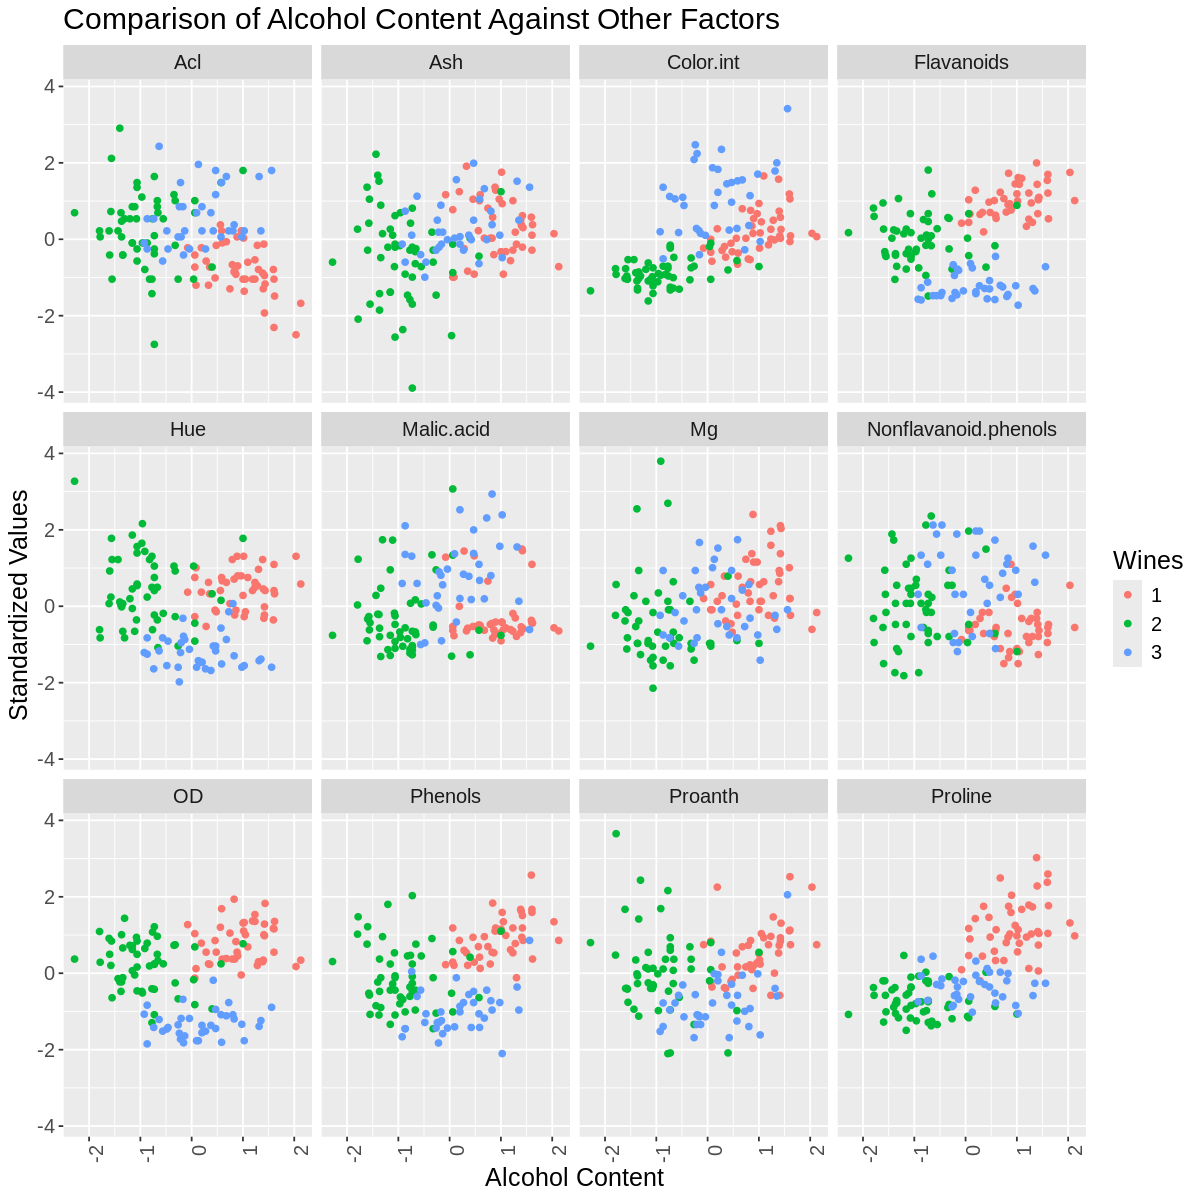

In [16]:
options (repr.plot.width = 10, repr.plot.height = 10)
wine_plot_facet <- wine_train_alcohol |>
    ggplot (aes (x = Alcohol, y = values, color = Wine)) +
    ggtitle ("Comparison of Alcohol Content Against Other Factors") +
    geom_point () +
    labs (x = "Alcohol Content",
          y = " Standardized Values",
          color = "Wines") +
    facet_wrap (~attributes) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    theme(text = element_text(size=15))
wine_plot_facet

**Method**

Numerous columns hold chemical significance, yet our understanding to analyze these variables comfortably remains limited. Despite this, most variables prove useful for prediction, with the three regions being clustered into three sections across all graphs. Notably, Alcohol Content, flavonoids, Hue, and Phenols exhibit significant deviations, allowing for the creation of a highly accurate model. This can be effectively visualized through a scatter plot like the one above, depicting differing values colored according to the type of wine.

**Expected Outcomes and Significance**

We anticipate discovering notable variations in attribute values among different wine regions, which will aid our classification analysis and modeling efforts. These findings and analysis can be used for wine fraud detection, which is a significant issue where fake wines pose as expensive luxary wines through added sweeteners and even harmful chemicals (https://en.wikipedia.org/wiki/Wine_fraud). Thus this model could potentially assist in authenticating rare and expensive wines for a curator's collection. Considering that wine evolves over time, it's essential to acknowledge that while this model accurately predicts wines at age 'n', certain data values may alter with aging. Future inquiries may question "How accurate is this model predicting aged wine?", or "What age is the wine in this model?".